# Uncertainty Quantification for Regression with MAPIE

In [1]:
import sys
sys.path.append("..")

from pathlib import Path
from scipy import stats
from sklearn.linear_model import QuantileRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score, train_test_split

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time

from lib.get_config import get_config
cfg = get_config('../config/config.yaml')
import lib.plot_utils as plot_utils

# Set matplotlib default color
from cycler import cycler
import matplotlib as mpl
mpl.rcParams['axes.prop_cycle'] = cycler(color=plot_utils.cb_qualitative_ptol())

Load config file >> ../config/config.yaml


In [2]:
y_rescaled = lambda y_label: yscaler.inverse_transform(np.asarray(y_label)[...,np.newaxis]).flatten()
df = pd.read_csv(Path(cfg['data_dir'], 'catalogue', 'sdssdr16q_prop.csv'), sep=',', header=0)

## Define functions

In [3]:
def evalcv_prederror(estimator, X_test, y_test, y_pred, cv=10):
    """Evaluate prediction error with cross-validation"""
    
    mae = np.abs(y_test - y_pred).mean()
    mae_cv = np.abs(cross_val_score(estimator, X=X_test, y=y_test, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1))
    rmse = np.sqrt(((y_test - y_pred)**2).mean())
    rmse_cv = np.sqrt(np.abs(cross_val_score(estimator, X=X_test, y=y_test, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)))
    
    return {'mae': mae, 'mae_mean': np.mean(mae_cv), 'mae_stddev': np.std(mae_cv),
            'rmse': rmse, 'rmse_mean': np.mean(rmse_cv), 'rmse_stddev': np.std(rmse_cv)}


In [4]:
def plot_predvstargetuq(target, pred, lower, upper, metrics=None, tstd=None, ax=None, onetoone_refloc=0, xlabel=None, ylabel=None, plot_legend=True, save_plotname=False):
    """Plot prediction against target"""
    
    color = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'])
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(5,5))
    # Conformal prediction
    ax.plot(target, pred, marker='.', markersize=2, linestyle=':', lw=1, alpha=0.5, zorder=5, rasterized=True, label='prediction')
    ax.fill_between(target, lower, upper, color=next(color), edgecolor='none', alpha=0.4, zorder=5, label='prediction interval')
    # Metrics
    if isinstance(metrics, dict):
        yoffset = 0.
        for k, v in metrics.items():
            ax.annotate(f"{k}={v:.3f}", xy=(0.05, 0.95+yoffset), xycoords='axes fraction')
            yoffset -= 0.05
    ax = plot_utils.ax_square(ax, identitystd=tstd, identitystd_shade='gray', plot_identity=True)
    ax.set_xlabel('Target' if xlabel is None else xlabel)
    ax.set_ylabel('Prediction' if ylabel is None else ylabel)
    if plot_legend: ax.legend(loc='lower right', markerscale=3, handletextpad=0.3)
    if save_plotname: fig.savefig(save_plotname if isinstance(save_plotname, str) else 'plots/predvstargetuq.pdf', bbox_inches='tight')
    # plt.show()


def plot_allpredvstargetuq(uq_dict, tstd=0.5, xlabel=None, ylabel=None, save_plotname=False):
    """Plot prediction against target for all uncertainty quantification methods"""
    fig, axes = plt.subplots(2, 3, figsize=(10, 7.5), sharex=True, sharey=True, gridspec_kw={'hspace': 0., 'wspace': 0.})
    nstrategy = len(uq_dict.keys())
    for i, (ax, s) in enumerate(zip(axes.flatten(), uq_dict.keys())):
        plot_predvstargetuq(uq_dict[s]['target'], uq_dict[s]['pred'], uq_dict[s]['lower'], uq_dict[s]['upper'], metrics=uq_dict[s]['pierr_metric'],
                            tstd=tstd, ax=ax, onetoone_refloc=8, xlabel='', ylabel='',
                            plot_legend=True if i==(nstrategy-1) else False, save_plotname=False)
        if i >= nstrategy-3:
            ax.set_xlabel(xlabel)
        if (i % 3) == 0:
            ax.set_ylabel(ylabel)
        ax.set_title(s, fontsize=10)
    if save_plotname: fig.savefig(save_plotname if isinstance(save_plotname, str) else 'plots/allpredvstargetuq.pdf', bbox_inches='tight')
    plt.show()


def plot_respicpvsalpha(df_picp, save_plotname=False):
    """Plot residual PICP-nominal against nominal confidence level"""
    nominal_coverage = 1 - df_picp.index.to_numpy()
    fig, ax = plt.subplots(figsize=(6, 4))
    for strategy in df_picp.columns:
        r2scorepercent = 100.*r2_score(nominal_coverage, df_picp[strategy], force_finite=False)
        ax.plot(nominal_coverage, df_picp[strategy]-nominal_coverage, '.-', markersize=10, lw=1, label=rf"$R^{2}_\mathrm{{{strategy.replace('_', ' ')}}}={r2scorepercent:.2f}$%")
    ax.axhline(y=0, ls='--', color='gray', alpha=0.6)
    ax.set_xlim(0, 1)
    ax.legend(handlelength=1.5, labelspacing=0.2, loc='upper center', ncol=2, bbox_to_anchor=(0.5,1.3))
    ax.set_xlabel("Nominal Confidence Level")
    ax.set_ylabel(r"PICP $-$ Nominal Confidence Level")
    if save_plotname: fig.savefig(save_plotname if isinstance(save_plotname, str) else 'plots/respicpvsalpha.pdf', bbox_inches='tight')
    plt.show()


def plot_mpiwvsalpha(df_mpiw, save_plotname=False):
    """Plot MPIW against nominal confidence level"""
    nominal_coverage = 1 - df_mpiw.index.to_numpy()
    fig, ax = plt.subplots(figsize=(6, 4))
    for strategy in df_mpiw.columns:
        ax.plot(nominal_coverage, df_mpiw[strategy], '.-', markersize=10, lw=1, label=strategy)
    ax.set_xlim(0, 1)
    ax.set_ylim(None, 1)
    ax.legend()
    ax.set_xlabel("Nominal Confidence Level")
    ax.set_ylabel(r'$\log$ MPIW $[M_{\odot}]$')
    if save_plotname: fig.savefig(save_plotname if isinstance(save_plotname, str) else 'plots/mpiwvsalpha.pdf', bbox_inches='tight')
    plt.show()


## For H$\beta$ virial BH mass

### Load output files

In [5]:
# Features
logdir_exp = Path(cfg['data_dir'], 'logs', '20230422/002629_LOGMBH_HB_DenseEncoder')

datasplit_idx = pd.read_pickle(Path(logdir_exp, 'datasplitidx.pkl'))
datasplit_idx['valid'], datasplit_idx['test'] = train_test_split(datasplit_idx['test'], test_size=cfg['frac_test_size'], random_state=cfg['seed'])
df_features = pd.read_pickle(Path(logdir_exp, 'features.pkl'))
yscaler = pd.read_pickle(Path(logdir_exp, 'yscaler.pkl'))

feature_keys = [k for k in df_features.columns if isinstance(k, int)]
dffeatures_train = df_features.loc[datasplit_idx['train']]
dffeatures_valid = df_features.loc[datasplit_idx['valid']]
dffeatures_test = df_features.loc[datasplit_idx['test']]
df_test = pd.merge(dffeatures_test['objid'], df, how='inner', left_on=['objid'], right_on=['OBJID'])

In [6]:
# Regressors
estimator = pd.read_pickle(Path(logdir_exp, 'estimator_optim.pkl'))
print(f"Best estimator >> {estimator}")
estimator_q = pd.read_pickle(Path(logdir_exp, 'estimatorq_optim.pkl'))
print(f"Best estimator >> {estimator_q}")
y_pred_hbeta, y_pis_hbeta, uq_dict = pd.read_pickle(Path(logdir_exp, 'mapieuq_pred.pkl'))
df_picp = pd.read_pickle(Path(logdir_exp, 'mapieuq_picp_alpha.pkl'))
df_mpiw = pd.read_pickle(Path(logdir_exp, 'mapieuq_mpiw_alpha.pkl'))

Best estimator >> GradientBoostingRegressor(learning_rate=0.013264961159866528, max_depth=26,
                          max_leaf_nodes=15, n_estimators=251, random_state=42)
Best estimator >> GradientBoostingRegressor(alpha=0.5, learning_rate=0.050768531039396936,
                          loss='quantile', max_depth=20, max_leaf_nodes=24,
                          n_estimators=152, random_state=42)


### Prediction results

In [7]:
# Evaluate prediction error
pd.DataFrame(
    {'NeuralNetwork': evalcv_prederror(estimator, dffeatures_test[feature_keys].to_numpy(), y_rescaled(dffeatures_test['scaled_label']), y_rescaled(dffeatures_test['output']), cv=10)} | \
    {str(estimator).rpartition('(')[0]: evalcv_prederror(estimator, dffeatures_test[feature_keys].to_numpy(), dffeatures_test['label'].to_numpy(), y_pred_hbeta['cv_plus'], cv=10)} | \
    {str(estimator_q).rpartition('(')[0]+'_quantile': evalcv_prederror(estimator_q, dffeatures_test[feature_keys].to_numpy(), dffeatures_test['label'].to_numpy(), y_pred_hbeta['cqr'], cv=10)}
).style.format('{:.3f}')


,NeuralNetwork,GradientBoostingRegressor,GradientBoostingRegressor_quantile
mae,0.143,0.138,0.138
mae_mean,0.144,0.144,0.144
mae_stddev,0.013,0.013,0.012
rmse,0.194,0.187,0.187
rmse_mean,0.198,0.198,0.198
rmse_stddev,0.026,0.026,0.024


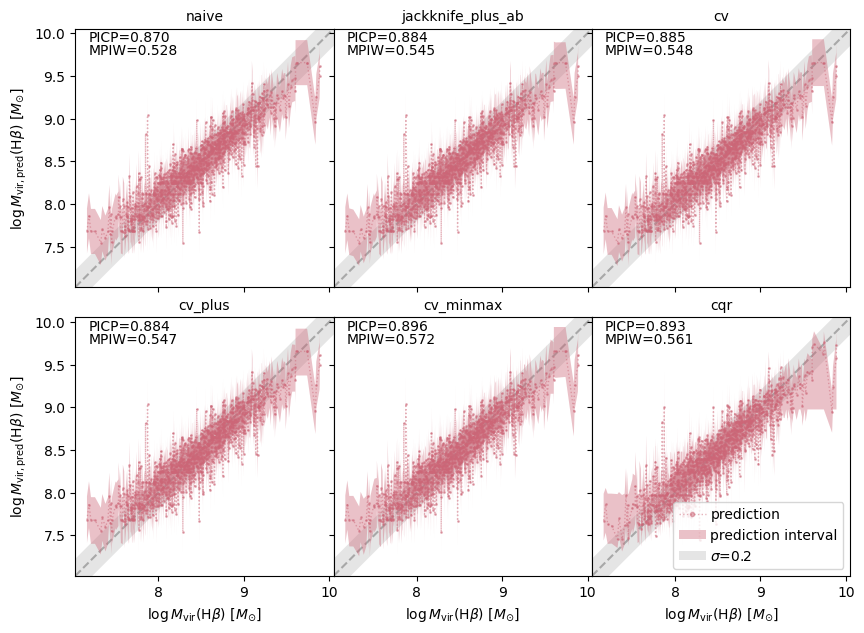

In [8]:
# For single method
# s = 'cqr'
# plot_predvstargetuq(uq_dict[s]['target'], uq_dict[s]['pred'], uq_dict[s]['lower'], uq_dict[s]['upper'], metrics=uq_dict[s]['pierr_metric'], tstd=0.5, ax=None, onetoone_refloc=8,
#                     xlabel=r'$\log M_{\mathrm{vir}}(\mathrm{H}\beta)\ [M_{\odot}]$', ylabel=r'$\log M_{\mathrm{vir,pred}}(\mathrm{H}\beta)\ [M_{\odot}]$',
#                     save_plotname=False)

# For all
plot_allpredvstargetuq(uq_dict, tstd=0.2,
                        xlabel=r'$\log M_{\mathrm{vir}}(\mathrm{H}\beta)\ [M_{\odot}]$', ylabel=r'$\log M_{\mathrm{vir,pred}}(\mathrm{H}\beta)\ [M_{\odot}]$',
                        save_plotname='plots/allpredvstargetuq_hbeta.pdf')

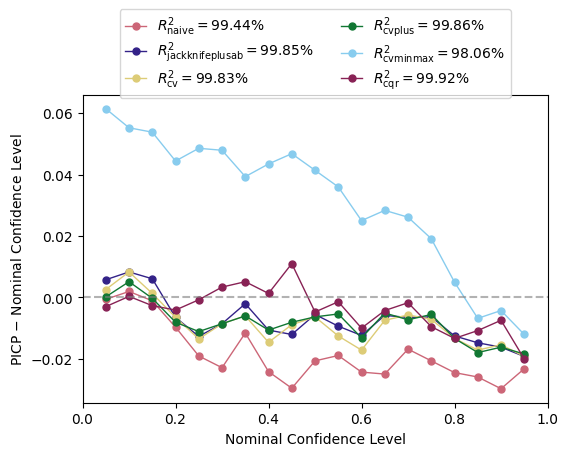

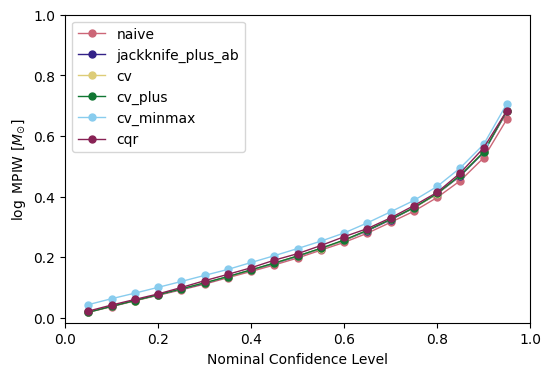

In [9]:
plot_respicpvsalpha(df_picp, save_plotname='plots/respicpvsalpha_hbeta.pdf')
plot_mpiwvsalpha(df_mpiw, save_plotname='plots/mpiwvsalpha_hbeta.pdf')

## For MgII virial BH mass

### Load output files

In [10]:
# Features
logdir_exp = Path(cfg['data_dir'], 'logs', '20230422/030635_LOGMBH_MGII_DenseEncoder')

datasplit_idx = pd.read_pickle(Path(logdir_exp, 'datasplitidx.pkl'))
datasplit_idx['valid'], datasplit_idx['test'] = train_test_split(datasplit_idx['test'], test_size=cfg['frac_test_size'], random_state=cfg['seed'])
df_features = pd.read_pickle(Path(logdir_exp, 'features.pkl'))
yscaler = pd.read_pickle(Path(logdir_exp, 'yscaler.pkl'))

feature_keys = [k for k in df_features.columns if isinstance(k, int)]
dffeatures_train = df_features.loc[datasplit_idx['train']]
dffeatures_valid = df_features.loc[datasplit_idx['valid']]
dffeatures_test = df_features.loc[datasplit_idx['test']]

In [11]:
# Regressors
estimator = pd.read_pickle(Path(logdir_exp, 'estimator_optim.pkl'))
print(f"Best estimator >> {estimator}")
estimator_q = pd.read_pickle(Path(logdir_exp, 'estimatorq_optim.pkl'))
print(f"Best estimator >> {estimator_q}")
y_pred_mgii, y_pis_mgii, uq_dict = pd.read_pickle(Path(logdir_exp, 'mapieuq_pred.pkl'))
df_picp = pd.read_pickle(Path(logdir_exp, 'mapieuq_picp_alpha.pkl'))
df_mpiw = pd.read_pickle(Path(logdir_exp, 'mapieuq_mpiw_alpha.pkl'))

Best estimator >> GradientBoostingRegressor(learning_rate=0.013264961159866528, max_depth=26,
                          max_leaf_nodes=15, n_estimators=251, random_state=42)
Best estimator >> GradientBoostingRegressor(alpha=0.5, learning_rate=0.050768531039396936,
                          loss='quantile', max_depth=20, max_leaf_nodes=24,
                          n_estimators=152, random_state=42)


### Prediction results

In [12]:
# Evaluate prediction error
pd.DataFrame(
    {'NeuralNetwork': evalcv_prederror(estimator, dffeatures_test[feature_keys].to_numpy(), y_rescaled(dffeatures_test['scaled_label']), y_rescaled(dffeatures_test['output']), cv=10)} | \
    {str(estimator).rpartition('(')[0]: evalcv_prederror(estimator, dffeatures_test[feature_keys].to_numpy(), dffeatures_test['label'].to_numpy(), y_pred_mgii['cv_plus'], cv=10)} | \
    {str(estimator_q).rpartition('(')[0]+'_quantile': evalcv_prederror(estimator_q, dffeatures_test[feature_keys].to_numpy(), dffeatures_test['label'].to_numpy(), y_pred_mgii['cqr'], cv=10)}
).style.format('{:.3f}')


,NeuralNetwork,GradientBoostingRegressor,GradientBoostingRegressor_quantile
mae,0.164,0.163,0.163
mae_mean,0.169,0.169,0.169
mae_stddev,0.011,0.011,0.011
rmse,0.214,0.213,0.214
rmse_mean,0.221,0.222,0.222
rmse_stddev,0.017,0.017,0.015


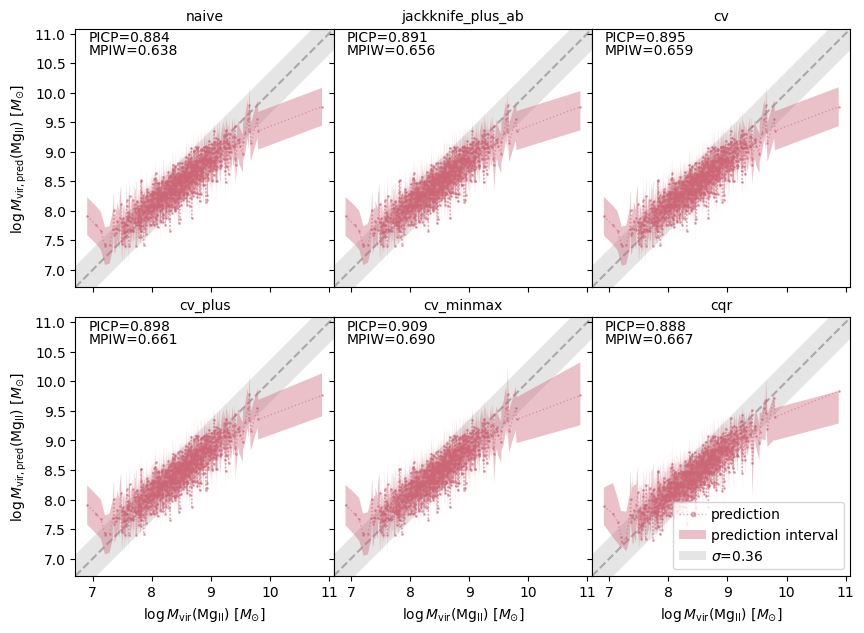

In [13]:
# For single method
# s = 'cqr'
# plot_predvstargetuq(uq_dict[s]['target'], uq_dict[s]['pred'], uq_dict[s]['lower'], uq_dict[s]['upper'], metrics=uq_dict[s]['pierr_metric'], tstd=0.5, ax=None, onetoone_refloc=8,
#                     xlabel=r'$\log M_{\mathrm{vir}}(\mathrm{Mg}_{\mathrm{II}})\ [M_{\odot}]$', ylabel=r'$\log M_{\mathrm{vir,pred}}(\mathrm{Mg}_{\mathrm{II}})\ [M_{\odot}]$',
#                     save_plotname=False)

# For all
plot_allpredvstargetuq(uq_dict, tstd=0.36,
                       xlabel=r'$\log M_{\mathrm{vir}}(\mathrm{Mg}_{\mathrm{II}})\ [M_{\odot}]$', ylabel=r'$\log M_{\mathrm{vir,pred}}(\mathrm{Mg}_{\mathrm{II}})\ [M_{\odot}]$',
                       save_plotname='plots/allpredvstargetuq_mgii.pdf')

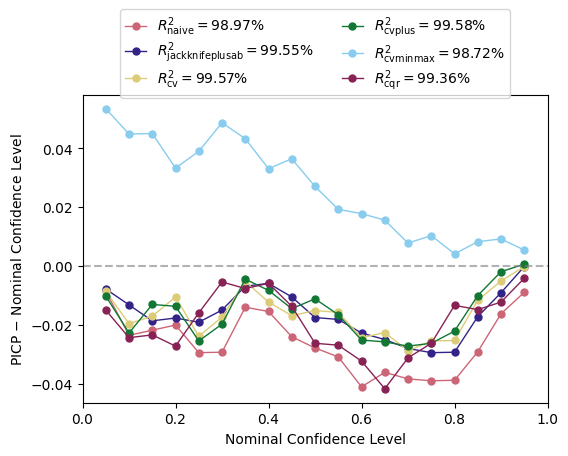

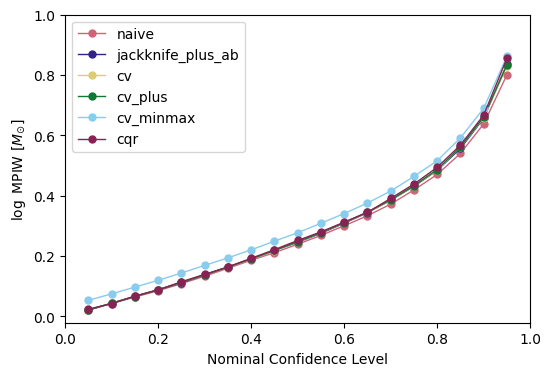

In [14]:
plot_respicpvsalpha(df_picp, save_plotname='plots/respicpvsalpha_mgii.pdf')
plot_mpiwvsalpha(df_mpiw, save_plotname='plots/mpiwvsalpha_mgii.pdf')

## Compare H$\beta$ and MgII virial BH mass

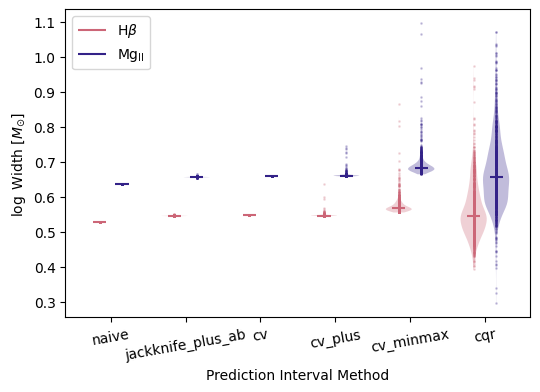

In [15]:
def plotviolin_widthuq(y_pis_hbeta, y_pis_mgii, save_plotname=False):
    """Violin plot of prediction interval widths for uncertainty quantification methods"""
    strategies = y_pis_hbeta.keys()
    xtick_position = np.arange(0, len(strategies))*2
    shift = 0.3
    vp_kwargs = {'widths': 0.7, 'showmedians': True, 'showextrema': False}
    fig, ax = plt.subplots(figsize=(6,4))
    vp_hb = ax.violinplot([y_pis_hbeta[strategy][:,1]-y_pis_hbeta[strategy][:,0] for strategy in strategies], positions=xtick_position-shift, **vp_kwargs)
    vp_mgii = ax.violinplot([y_pis_mgii[strategy][:,1]-y_pis_mgii[strategy][:,0] for strategy in strategies], positions=xtick_position+shift, **vp_kwargs)
    for i, strategy in enumerate(strategies):
        ax.scatter(np.repeat(xtick_position[i]-shift, len(y_pis_hbeta[strategy])), y_pis_hbeta[strategy][:,1]-y_pis_hbeta[strategy][:,0], color=vp_hb['cmedians'].get_color(), s=1, alpha=0.2)
        ax.scatter(np.repeat(xtick_position[i]+shift, len(y_pis_mgii[strategy])), y_pis_mgii[strategy][:,1]-y_pis_mgii[strategy][:,0], color=vp_mgii['cmedians'].get_color(), s=1, alpha=0.2)
    ax.set_xticks(xtick_position, labels=strategies, rotation=10)
    ax.legend(handles=[vp_hb['cmedians'], vp_mgii['cmedians']], labels=[r'H$\beta$', r'Mg$_{\mathrm{II}}$'], loc='upper left')
    ax.set_xlabel('Prediction Interval Method')
    ax.set_ylabel(r'$\log$ Width $[M_{\odot}]$')
    if save_plotname: fig.savefig(save_plotname if isinstance(save_plotname, str) else 'plots/violinwidth.pdf', bbox_inches='tight')
    plt.show()

plotviolin_widthuq(y_pis_hbeta, y_pis_mgii, save_plotname='plots/violinwidth.pdf')

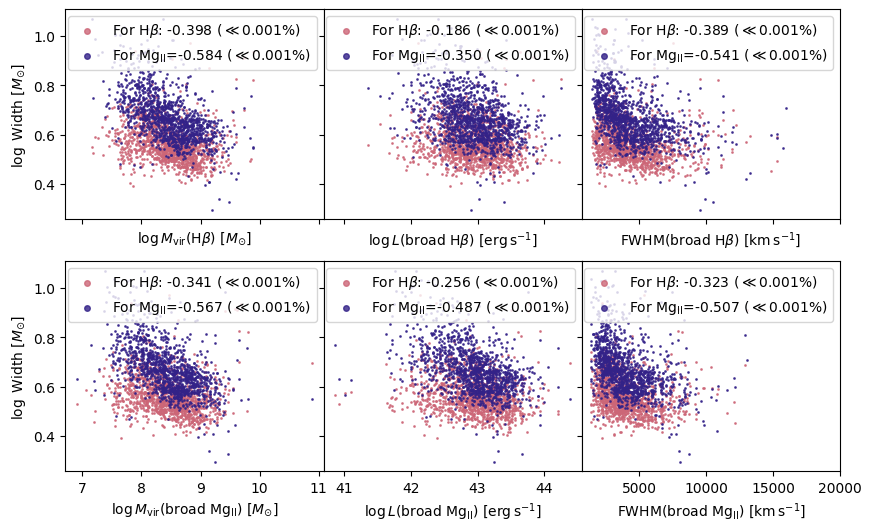

In [17]:
# Prediction interval widths against selected parameters

param_label = {'LOGMBH_HB': r'$\log M_{\mathrm{vir}}(\mathrm{H}\beta)\ [M_{\odot}]$',
               'HBETA_BR_LOGL': r'$\log L(\mathrm{broad\ H}\beta)\ [\mathrm{erg\,s}^{-1}]$',
               'HBETA_BR_FWHM': r'FWHM$(\mathrm{broad\ H}\beta)\ [\mathrm{km\,s}^{-1}]$',
               'LOGMBH_MGII': r'$\log M_{\mathrm{vir}}(\mathrm{broad\ Mg}_{\mathrm{II}})\ [M_{\odot}]$',
               'MGII_BR_LOGL': r'$\log L(\mathrm{broad\ Mg}_{\mathrm{II}})\ [\mathrm{erg\,s}^{-1}]$',
               'MGII_BR_FWHM': r'FWHM$(\mathrm{broad\ Mg}_{\mathrm{II}})\ [\mathrm{km\,s}^{-1}]$',
              }
fig, axes = plt.subplots(2, 3, figsize=(10,6), sharex='col', sharey=True, gridspec_kw={'wspace': 0})
axs = axes.flatten()
for i, col in enumerate(['LOGMBH_HB', 'HBETA_BR_LOGL', 'HBETA_BR_FWHM', 'LOGMBH_MGII', 'MGII_BR_LOGL', 'MGII_BR_FWHM']):
    # Evaluate Spearman correlation
    spearman_pvalue_fmt = lambda pval: r"$\ll 0.001$%" if pval*100.<0.001 else f"{pval*100.:.3e}%" # Format p-value
    spearman_hbeta = stats.spearmanr(df_test[col], y_pis_hbeta['cqr'][:,1]-y_pis_hbeta['cqr'][:,0])
    spearman_mgii = stats.spearmanr(df_test[col], y_pis_mgii['cqr'][:,1]-y_pis_mgii['cqr'][:,0])
    axs[i].scatter(df_test[col], y_pis_hbeta['cqr'][:,1]-y_pis_hbeta['cqr'][:,0], s=1, rasterized=True, alpha=0.8, label=rf"For H$\beta$: {spearman_hbeta.correlation:.3f} ({spearman_pvalue_fmt(spearman_hbeta.pvalue)})")
    axs[i].scatter(df_test[col], y_pis_mgii['cqr'][:,1]-y_pis_mgii['cqr'][:,0], s=1, rasterized=True, alpha=0.8, label=rf"For Mg$_{{\mathrm{{II}}}}$={spearman_mgii.correlation:.3f} ({spearman_pvalue_fmt(spearman_mgii.pvalue)})")
    axs[i].set_xlabel(param_label[col])
    axs[i].legend(loc='upper right', markerscale=4)
    if 'FWHM' in col:
        axs[i].set_xlim(None, 20000)
    if i%3 == 0:
        axs[i].set_ylabel(r'$\log$ Width $[M_{\odot}]$')
fig.savefig('plots/widthvsparams_cqr.pdf', bbox_inches='tight')
plt.show()


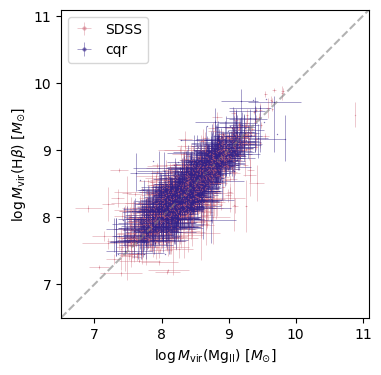

In [18]:
def plot_mvirhbvsmgii(df, ypred_mgii, ypis_mgii, ypred_hbeta, ypis_hbeta, label, fit_odr=False, save_plotname=False):
    """Plot of virial black hole mass of Hb against MgII"""
    
    def linear_func(b, x):
        """Linear function"""
        return b[0]*x + b[1]
    
    def run_odr(x, y, xerr, yerr):
        """Fit ordinary distance regression"""
        import scipy.odr as odr
        linear = odr.Model(linear_func)
        data = odr.Data(x, y, wd=1./xerr, we=1./yerr)
        fit = odr.ODR(data, linear, beta0=[1., 0.])
        output = fit.run()
        return output
    
    list_err_nn = lambda list_err: [0 if le<0 else le for le in list_err] # Convert negative error to 0
    err_kwargs = {'fmt': 'o', 'markersize': 1., 'lw': 0.5, 'markeredgecolor': 'none', 'rasterized': True}
    fig, ax = plt.subplots(figsize=(4,4))
    ax.errorbar(df['LOGMBH_MGII'], df['LOGMBH_HB'],
                xerr=df['LOGMBH_MGII_ERR'], yerr=df['LOGMBH_HB_ERR'],
                label='SDSS', alpha=0.5, **err_kwargs)
    # Errors are plotted every 3 points to avoid clutter
    ax.errorbar(ypred_mgii, ypred_hbeta,
                xerr=[list_err_nn(ypred_mgii-ypis_mgii[:,0]), list_err_nn(ypis_mgii[:,1]-ypred_mgii)],
                yerr=[list_err_nn(ypred_hbeta-ypis_hbeta[:,0]), list_err_nn(ypis_hbeta[:,1]-ypred_hbeta)],
                label=label, errorevery=3, alpha=0.6, **err_kwargs)
    
    # Fit ODR
    if fit_odr:
        regression = run_odr(df['LOGMBH_MGII'], df['LOGMBH_HB'], df['LOGMBH_MGII_ERR'], df['LOGMBH_HB_ERR'])
        print("ODR FIT FOR SDSS ...")
        print(regression.pprint())
        ax.plot(df['LOGMBH_MGII'], linear_func(regression.beta, df['LOGMBH_MGII']), label=f"ODR fit for SDSS")
        regression = run_odr(ypred_mgii, ypred_hbeta, (ypis_mgii[:,1]-ypis_mgii[:,0])/2., (ypis_hbeta[:,1]-ypis_hbeta[:,0])/2.)
        print(f"ODR FIT FOR {label.upper()} ...")
        print(regression.pprint())
        ax.plot(ypred_mgii, linear_func(regression.beta, ypred_mgii), label=f"ODR fit for {label}")
    
    ax.legend(handlelength=1.5, markerscale=3)
    ax = plot_utils.ax_square(ax, identitystd=None, identitystd_shade=False, plot_identity=True)
    ax.set_xlabel(r'$\log M_{\mathrm{vir}}(\mathrm{Mg}_{\mathrm{II}})\ [M_{\odot}]$')
    ax.set_ylabel(r'$\log M_{\mathrm{vir}}(\mathrm{H}\beta)\ [M_{\odot}]$')
    if save_plotname: fig.savefig(save_plotname if isinstance(save_plotname, str) else 'plots/mvirhbvsmgii.pdf', bbox_inches='tight', dpi=150)
    plt.show()


plot_mvirhbvsmgii(df_test, y_pred_mgii['cqr'], y_pis_mgii['cqr'], y_pred_hbeta['cqr'], y_pis_hbeta['cqr'], label='cqr', fit_odr=False, save_plotname='plots/mvirhbvsmgii_cqr.pdf')

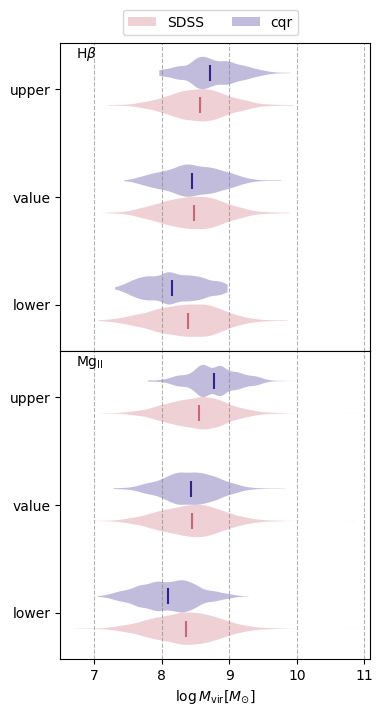

In [19]:
def plotviolin_pirange(ys_dict, label=None, xlabel=None, save_plotname=False):
    """
    Violin plot of prediction interval range for actual and prediction
    
    Parameters
    ----------
        ys_dict: dict of {'line': [[lower, value, upper] for actual, [lower, value, upper] for prediction]}
    """
    offset_group, width = 1, 0.3
    vp_bodies = []
    fig, axes = plt.subplots(2, 1, figsize=(4,8), sharex=True, gridspec_kw={'hspace': 0})
    for i, (k, val) in enumerate(ys_dict.items()):
        axes[i].annotate(k, xy=(0.05, 0.95), xycoords='axes fraction') # Annotate line
        axes[i].grid(axis='x', color='gray', ls='--', alpha=0.6) # Add grid
        axes[i].set_yticks(np.arange(0+width/2, len(list(ys_dict.values())[0][0])+width/2, offset_group), labels=['lower', 'value', 'upper'])
        offset_subgroup = 0
        for v in val:
            vp = axes[i].violinplot(v, positions=[offset_subgroup, offset_group+offset_subgroup, 2*offset_group+offset_subgroup], widths=width, vert=False, showextrema=False, showmedians=True)
            vp_bodies.append(vp['bodies'][0])
            offset_subgroup += width
    axes[-1].set_xlabel('' if xlabel is None else xlabel)
    fig.legend(vp_bodies, ['SDSS', 'prediction' if label is None else label], loc='upper center', bbox_to_anchor=(0.5,0.93), ncol=2)
    if save_plotname: fig.savefig(save_plotname if isinstance(save_plotname, str) else 'plots/violinpi.pdf', bbox_inches='tight')
    plt.show()


ys_dict = {r'H$\beta$': [[df_test['LOGMBH_HB']-df_test['LOGMBH_HB_ERR'], df_test['LOGMBH_HB'], df_test['LOGMBH_HB_ERR']+df_test['LOGMBH_HB']], # actual
                         [y_pis_hbeta['cqr'][:,0], y_pred_hbeta['cqr'], y_pis_hbeta['cqr'][:,1]]], # pred
           r'Mg$_{\mathrm{II}}$': [[df_test['LOGMBH_MGII']-df_test['LOGMBH_MGII_ERR'], df_test['LOGMBH_MGII'], df_test['LOGMBH_MGII_ERR']+df_test['LOGMBH_MGII']], # actual
                                   [y_pis_mgii['cqr'][:,0], y_pred_mgii['cqr'], y_pis_mgii['cqr'][:,1]]], # pred
          }
plotviolin_pirange(ys_dict, label='cqr', xlabel=r'$\log M_{\mathrm{vir}} [M_{\odot}]$', save_plotname='plots/violinpi_cqr.pdf')